<a href="https://colab.research.google.com/github/omer-lebel/Perceptron-Linear-Logistic-Regression-From-Scratch/blob/main/Linear_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear Machine Learning Models
By Omer Lebel <br>
(with the kind help of all the AI ​​assistants the world currently has to offer 😉 )

## ⚙ Prepration





The MNIST dataset containe a collection of 70,000 labeled images of handwritten digits (0-9)

*   **Image size:** Each image is 28X28 pixel, resulting in a total of 784 pixel per imape.
*   **Grayscale:** The impages are greyscal, eith each pixel represented by a single intesity ranging from 0 (black) to 255 (white)

We will spilt the dataset into training set of 60,000 image, and test set of 10,000 images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick

In [ ]:
TEST_SIZE = 10000

# fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'] # X - data, Y - labels
m_samples, n_features = X.shape

# convert X to matrix 70k*784 and adding bias (col of 1s) to X
X = X.to_numpy()
X_with_bias = np.c_[X, np.ones(X.shape[0])]

# one hot encoding y (y_one_hot[i,j] = 1 if y[i] == j else 0)
y = y.to_numpy().astype(int)
y_one_hot = np.zeros((m_samples, 10), dtype=int)
y_one_hot[np.arange(m_samples), y] = 1

# spliting the data set into train and test
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X_with_bias, y_one_hot, test_size = TEST_SIZE, random_state=0)

# one hot encoding with -1 instead of 0
y_signed_train = np.where(y_train_onehot == 1, 1, -1)
y_signed_test = np.where(y_test_onehot == 1, 1, -1)

# y_true[i] = true digit of sample i
y_test_true = np.argmax(y_test_onehot, axis=1).astype(int)
y_train_true = np.argmax(y_train_onehot, axis=1).astype(int)

## ⚒ Utils


* confustion matrix
* accuracy score: ACC = ∑TPᵢ / (numer of samples)
* recall / sensitivity: TPR = TP/(TP+FN)

In [ ]:

def confusion_matrix(y_true, y_pred):
  """
  for both binary and molticlass
  """

  # init the matrix
  num_classes = max(np.max(y_true), np.max(y_pred)) + 1  # assume labesl are 0-index
  conf_matrix = np.zeros((num_classes,num_classes), dtype=int)

  # perform conf_matrix[true_label, pred_label] += 1
  np.add.at(conf_matrix, (y_true, y_pred), 1)

   # if it's binary classification, rearrange the matrix
  if num_classes == 2:
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]
    conf_matrix = np.array([[TP, FN], [FP, TN]])

  return conf_matrix


def accuracy_score(y_true, y_pred):
  """
  binary:     ACC = (TP+TN)/(numer of samples)
  multyclass: ACC =  ∑TPᵢ / (numer of samples)
  """
  return np.sum(y_pred == y_true) / y_true.shape[0]


def recall_score(y_true, y_pred): # aka TPR \ sensitivity
  """
  Suit only for binary classification
  """
  TP = np.sum((y_true == 1) & (y_pred == 1))
  FN = np.sum((y_true == 1) & (y_pred == 0))
  return TP / (TP + FN)


Graph and matric ploting
* plot multicalss confusion matrix
* plot 10 confution matrix side by side

In [ ]:
def plot_multiclass_confusion_matrix(conf_matrix, title="Confusion Matrix Heatmap"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()


def plot_confusion_matrices_side_by_side(conf_matrices_lst, title="Digit-wise Confusion Matrices"):

  colors = ['YlOrBr', 'OrRd', 'YlOrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

  # Create a figure with 2 rows and 5 columns
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))

  for digit, conf_matrix in enumerate(conf_matrices_lst):
    ax = axes[digit // 5, digit % 5]  # Access the correct subplot
    ax.set_title(f'Digit {digit}')

    #add the heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=colors[digit], ax=ax,
                xticklabels=["True", "False"], yticklabels=["True", "False"], cbar=False)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")

  fig.suptitle(title, fontsize=24)

  # add padding and scases
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.tight_layout(pad=2.0)

  plt.show()

# 🧠 Perceptron


In [ ]:
class Perceptron:
  def __init__(self, max_iter=1000, interval_snapshot=50):
    self.max_iter = max_iter
    self.interval_snapshot = interval_snapshot
    self._w = None
    self._train_history = [] # track w_pocket and E_in

  def fit(self, X, y):
    m_samples, n_features = X.shape

    self._w = np.zeros(n_features)
    w_pocket = self._w.copy()
    min_E_in = np.inf
    y_pred = self.predict(X)

    for i in tqdm(range(self.max_iter), desc= f'train with pocket algo'):
      # find random misclassified sample
      Xi, Yi = self._find_misclassified_sample(X, y, y_pred)
      if Xi is None: # no errors
        break

      # update w
      self._w += Yi*Xi

      # calculte the new E_in
      y_pred = self.predict(X)
      curr_E_in = self.Ein(y, y_pred)

      # update w_pocket if neaded
      if curr_E_in < min_E_in:
        w_pocket = self._w.copy()
        min_E_in = curr_E_in

      self._track_train_progress(i, w_pocket, min_E_in)

    self._w = w_pocket


  def predict(self, X, w=None):
    w = self._w if w is None else w
    return np.sign(X @ w)

  def get_w(self):
    return self._w

  def get_train_history(self):
    return self._train_history

  def Ein(self, y, y_pred):
    return np.sum(y_pred != y) / y.shape[0]


  def _find_misclassified_sample(self, X, y, y_pred):
    # identify misclassified sample indexes
    misclassified_indexes = np.where(y_pred != y)[0]

    # return a random misclassified sample, if any
    if misclassified_indexes.size > 0:
      random_index  = np.random.choice(misclassified_indexes)
      return X[random_index], y[random_index]

    return None, None

  def _track_train_progress(self, itr, w_pocket, cur_min_Ein):
    if itr % self.interval_snapshot == 0 or itr == self.max_iter - 1:
      self._train_history.append((itr, w_pocket, cur_min_Ein * 100))


**Note:** in order to find missplaces sample, we use the previus calculeing of y_pred that has been done in order to calcuclute E_in.

**Multiclass classifier (one-vs-all)** <br>
We will create 10 binary classifier - one for each digit (0 to 9). Then we'ill use the one-ve-all strategy : `h(x) = argmax(wᵀx)`



In [ ]:
class OneVsAllPerceptron:
  def __init__(self, max_iter=1000, interval_snapshot=50):
    self.max_iter = max_iter
    self.interval_snapshot = interval_snapshot
    self._classifiers = []
    self._W = None
    self._multiclass_train_history = []
    self._binary_train_history = []

  def fit(self, X, Y):
    m_samples, n_features = X.shape
    k_classes = Y.shape[1] # assume Y is one-hot sign matrix

    self._W = np.empty((n_features, 0))
    errors_track  = []
    w_track = []
    snapshot_itr = 0

    for class_idx in tqdm(range(k_classes), desc='train binary perceptron calssifier'):
      # Train a binary classifier for the current class
      clf = Perceptron(self.max_iter)
      clf.fit(X, Y[:, class_idx]) # use the idx-th col of Y

      # store the weights
      self._classifiers.append(clf)
      self._W = np.column_stack([self._W, clf.get_w()])

      # track history
      snapshot_itr, w_history , Ein_history = zip(*clf.get_train_history())
      errors_track.append(Ein_history)
      w_track.append(w_history)

    self._multiclass_train_history = self.combine_history(
        snapshot_itr, errors_track, w_track, k_classes)

  def predict(self, X, W=None):
    W = self._W if W is None else W
    return np.argmax(X @ W, axis=1)

  def get_W(self):
    return self._W

  def get_classifiers(self):
    return self._classifiers

  def Ein(self, y, y_pred):
    return np.sum(y_pred != y) / y.shape[0]

  def combine_history(self, iter, errors_track, w_track, k_classes):
    errors_track = np.array(errors_track)
    mean_error = np.mean(errors_track, axis=0)

    stack_W_track = []
    for snapshot_idx in tqdm(range(len(iter)), desc="combine W trackin"):
      # Select the snapshot_idx-th column from each row of w_track
      W = np.column_stack([w_track[class_idx][snapshot_idx]
                            for class_idx in range(k_classes)])
      stack_W_track.append(W)

    return [iter, stack_W_track, mean_error]

  def get_multiclass_train_history(self):
    return self._multiclass_train_history


## Train <br>

In [ ]:
# helper function to show model convergence

def plot_multiclass_perceptron_convergence(clf, interval_snapshot):
  train_history = clf.get_multiclass_train_history()
  iter, W_history , avg_binary_errors = train_history[0], train_history[1], train_history[2]

  test_errors, train_errors = calc_multiclass_errors_during_train(clf, W_history)

  plt.figure(figsize=(10, 6))
  plt.plot(iter, avg_binary_errors, marker='o', linestyle='-', color='green', label='mean loss of binary classifiers on train set')
  plt.plot(iter, test_errors, marker='o', linestyle='-', color='orange', label='test')
  plt.plot(iter, train_errors, marker='o', linestyle='-', color='blue', label='train')
  plt.title(f"Mean loss of Multiclass Clf During Training")
  plt.xlabel(f"Iteration (snapshot every {interval_snapshot} iteration)")
  plt.ylabel(f"Error percentage (%)")

  formatter = mtick.PercentFormatter()
  plt.gca().yaxis.set_major_formatter(formatter) #add % to ylabel
  plt.grid(True)
  plt.legend()
  plt.show()


def calc_multiclass_errors_during_train(clf, W_history):
  test_errors = []
  train_errors = []

  for i in tqdm(range(len(W_history)), desc="calculte multiclass errors throughout train"):
    W = np.array(W_history[i])

    y_train_preds = clf.predict(X_train, W)
    train_errors.append(clf.Ein(y_train_preds,y_train_true) * 100)

    y_test_preds = clf.predict(X_test, W)
    test_errors.append(clf.Ein(y_test_preds,y_test_true) * 100)

  return test_errors, train_errors

train binary perceptron calssifier:   0%|          | 0/10 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

combine W trackin:   0%|          | 0/15 [00:00<?, ?it/s]

calculte multiclass errors throughout train:   0%|          | 0/15 [00:00<?, ?it/s]

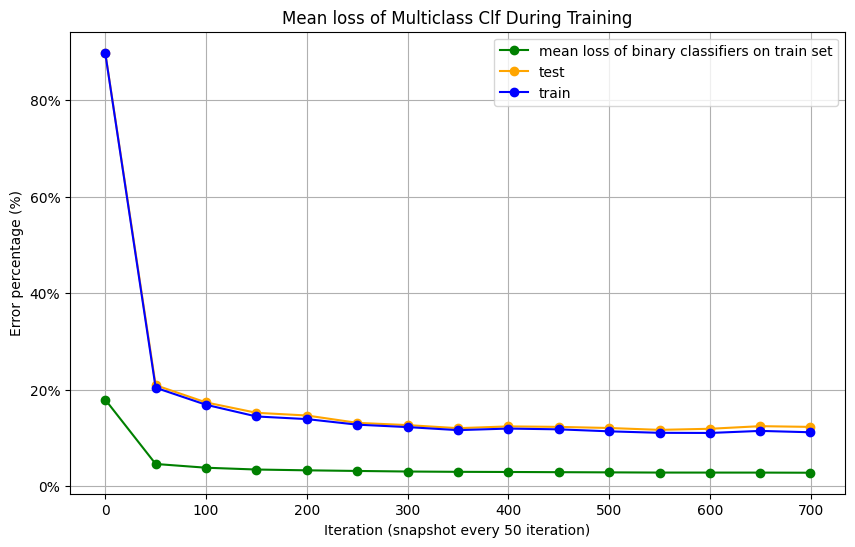

In [ ]:
MAX_PLA_ITER = 700
INTERVAL_SNAPSHOT = 50

# fit
pla_clf = OneVsAllPerceptron(MAX_PLA_ITER, INTERVAL_SNAPSHOT)
pla_clf.fit(X_train, y_signed_train)

#predict
y_pred = pla_clf.predict(X_test)

# plot convergence
plot_multiclass_perceptron_convergence(pla_clf, INTERVAL_SNAPSHOT)

## Model Evaluation

**Multiclass Classification Result**
* accurency = ∑TPᵢ / (numer of samples)
* confustion matrix

accurency: 87.69 %



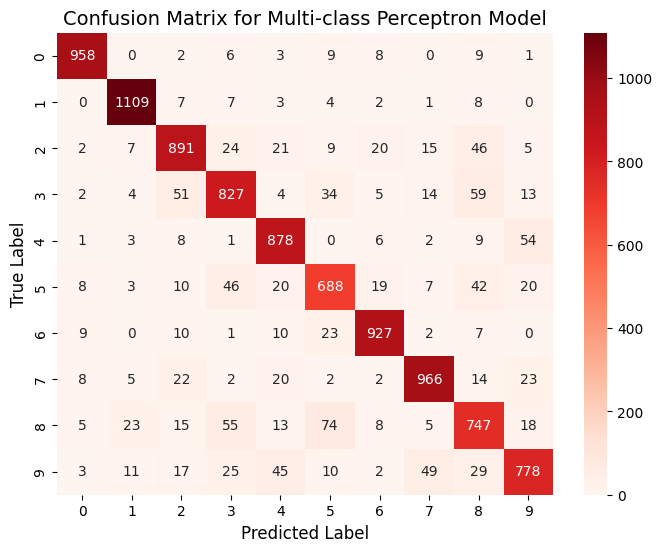

In [ ]:
# accurency
acc = accuracy_score(y_test_true, y_pred)
print(f"accurency: {100*acc} %\n")

# multy class confusion matrix
conf_mat = confusion_matrix(y_test_true, y_pred)
plot_multiclass_confusion_matrix(conf_mat,
                                 "Confusion Matrix for Multi-class Perceptron Model")

**Binary Classifier Results** <br>
For each classifier, we'll examine:

* **Confustion matrix**

* **Error progression graph** - visualizes how the classifier's error in sample and in test changes over the training iterations

* **Accurancy** - percentage of correctly classified samples. Calculte by the formula: `(TP+TN)/(TP+TN+FP+FN)`

* **Sensitivity** - percentage of actual positive samples that are correctly identified by the classifier. Calculte by the formula: `TP/(TP+FN)`

In [ ]:
# helper funcion to show the confiotion matrix and the pocket process side by side

def plot_pocket_progress(ax, train_history, digit):
  iterations, w_pocket_history , train_errors = zip(*train_history)
  test_errors = calc_test_errors_during_train(w_pocket_history)

  ax.plot(iterations, test_errors, marker=None, linestyle='-', color='blue', label='test')
  ax.plot(iterations, train_errors, marker=None, linestyle='-', color='orange', label='train')
  ax.set_title(f"Mean error throughout training")
  ax.set_xlabel(f"Iteration (snapshot every {INTERVAL_SNAPSHOT} iteration)")
  ax.set_ylabel(f"Mean error(%)")
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  ax.legend()

def calc_test_errors_during_train(w_pocket_history):
  w_pocket_history_np = np.array(w_pocket_history)
  y_preds = np.sign(X_test @ w_pocket_history_np.T) # each row is pred for diff w
  y_true = y_signed_test[:, digit]
  test_errors = np.mean(y_preds != y_true[:, None], axis=0) * 100
  return test_errors

def plot_conf_mat(ax, conf_matrix, digit):
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=["True", "False"], yticklabels=["True", "False"], ax=ax)
  ax.set_title(f"Confusion Matrix")
  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("Actual Labels")

show result:   0%|          | 0/10 [00:00<?, ?it/s]

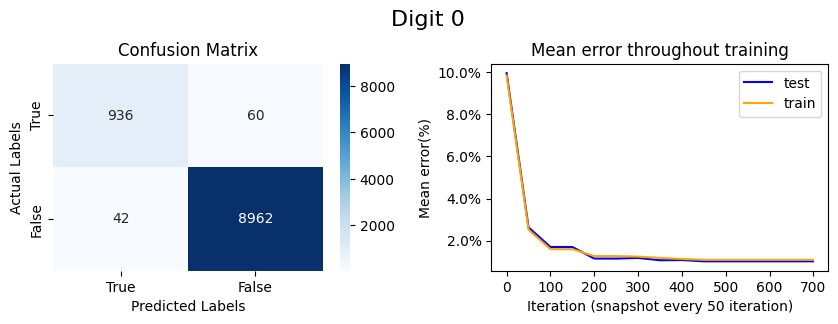

Accuracy(W0) = 98.980%
Sensitivity(W0) = 93.976%




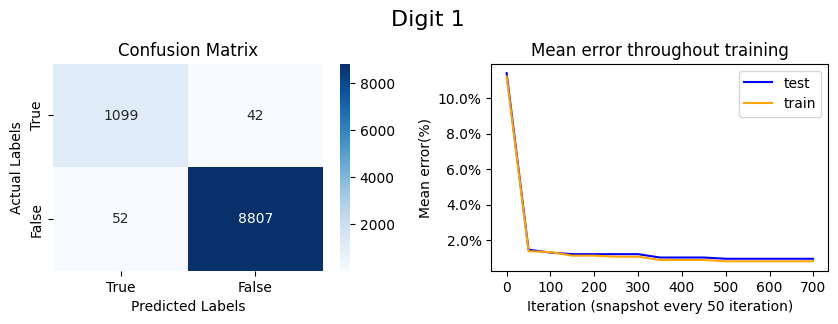

Accuracy(W1) = 99.060%
Sensitivity(W1) = 96.319%




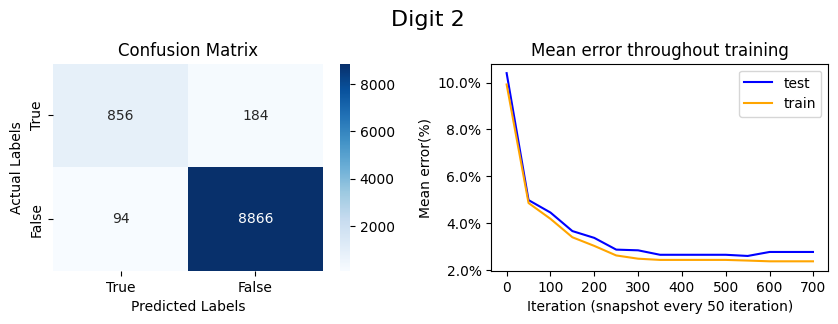

Accuracy(W2) = 97.220%
Sensitivity(W2) = 82.308%




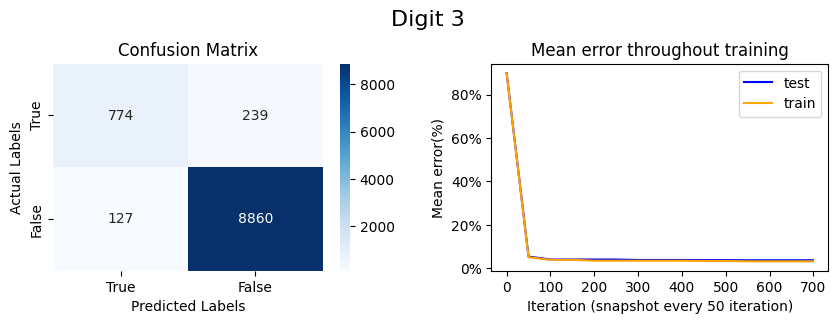

Accuracy(W3) = 96.340%
Sensitivity(W3) = 76.407%




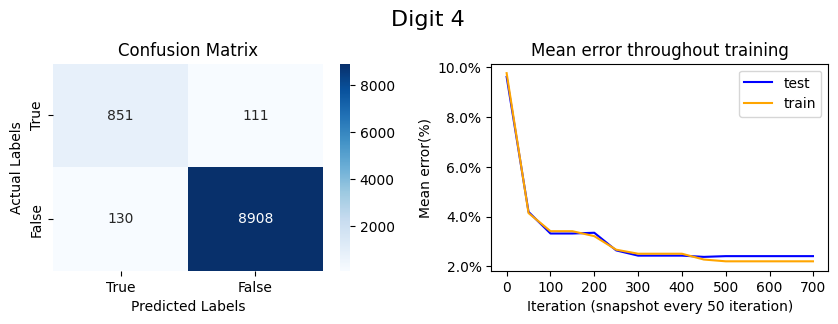

Accuracy(W4) = 97.590%
Sensitivity(W4) = 88.462%




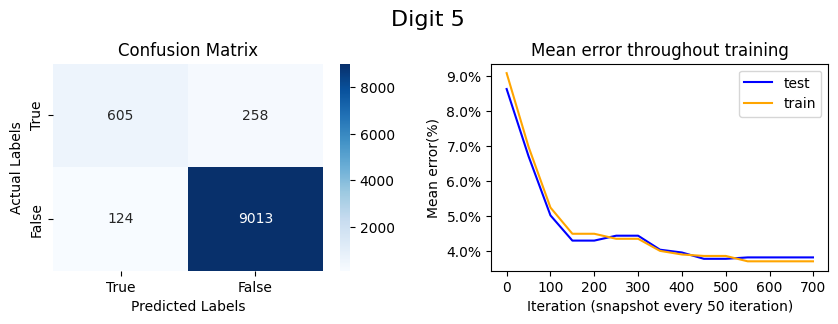

Accuracy(W5) = 96.180%
Sensitivity(W5) = 70.104%




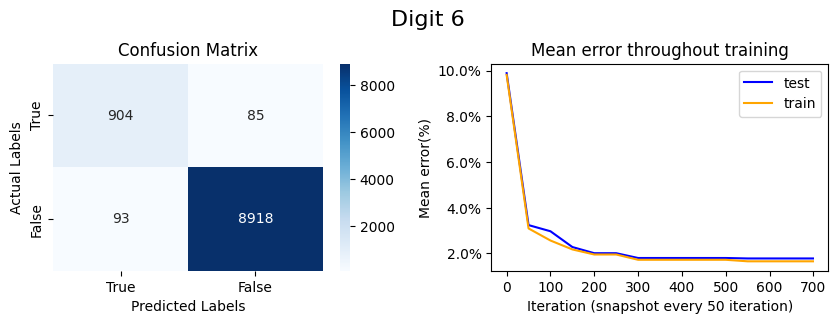

Accuracy(W6) = 98.220%
Sensitivity(W6) = 91.405%




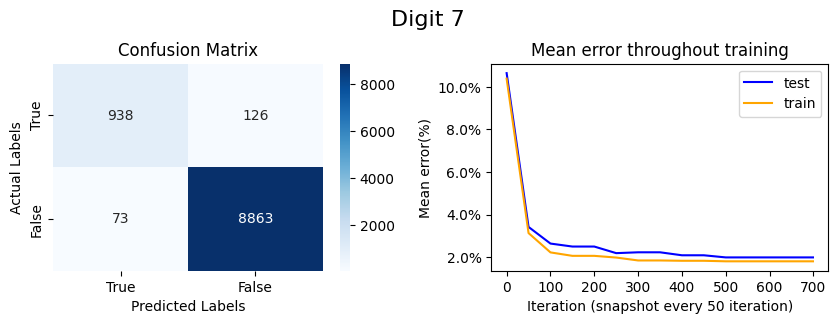

Accuracy(W7) = 98.010%
Sensitivity(W7) = 88.158%




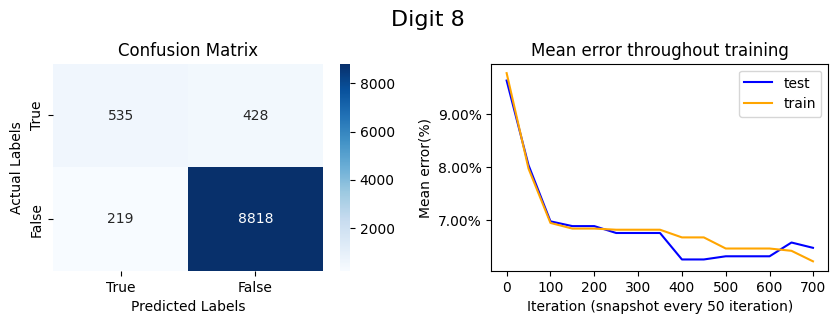

Accuracy(W8) = 93.530%
Sensitivity(W8) = 55.556%




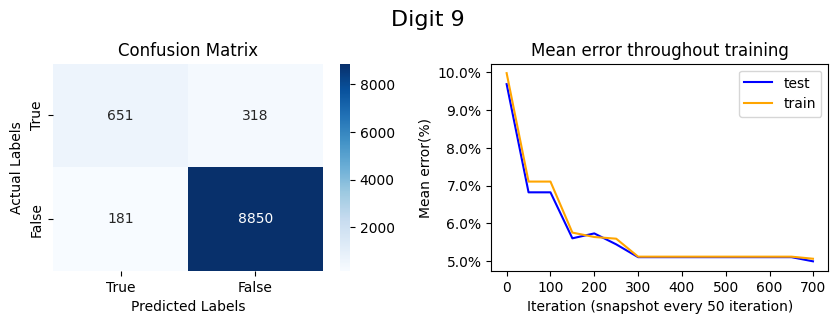

Accuracy(W9) = 95.010%
Sensitivity(W9) = 67.183%




In [ ]:
classifiers =  pla_clf.get_classifiers()
acc_arr = []

for digit in tqdm(range(10), desc='show result'):
  digit_clf = classifiers[digit]
  y_digit_pred = np.where(digit_clf.predict(X_test) == 1, 1, 0) # turn -1 to 0
  y_digit_true = y_test_onehot[:, digit] # use the digit-col of y


  fig, axes = plt.subplots(1, 2, figsize=(10, 3))

  # confision matrix
  conf_matrix = confusion_matrix(y_digit_true, y_digit_pred)
  plot_conf_mat(axes[0], conf_matrix, digit)

  # mean error progression throughout training
  train_history = digit_clf.get_train_history()
  plot_pocket_progress(axes[1], train_history, digit)

  fig.suptitle(f"Digit {digit}", fontsize=16)
  plt.subplots_adjust(wspace=0.3, top=0.8)
  plt.show()

  # accuracy
  acc = accuracy_score(y_digit_true, y_digit_pred)
  acc_arr.append(acc)
  print(f'Accuracy(W{digit}) = {acc*100:.3f}%')

  # sensitivity
  sensitivity = recall_score(y_digit_true, y_digit_pred)
  print(f'Sensitivity(W{digit}) = {sensitivity*100:.3f}%\n\n')

**Average accurency** <br>
It's worse pay attation to the fact that the avarge accurancy is mach better than the multiclass accurancy. <br>
This show us one of the weekness of the one-ve-all stragety.

In [ ]:
print(f'avg accurency: {np.mean(acc_arr)*100:.3f}%')

avg accurency: 97.014%


## Hyperparameter choice

Looking at the graphs of the mean errors of the binary classifiers, it appears that most improvement occurs within the first 200-400 iterations. After that, the rate of change slows significantly.
<br>
In order to make sure that "hard" digit like 8 and 9 will also be able to converge, it seems like chosing **max_iter=1000** would be a good choice if we want to ensure all the digits converge.
<br>
However, if we take a close look on the mean loss of the multiclass classifer graph, we can see that ater 400 iteration, there is almost no change at all. So it might be that some of the digit still didnt fully converge, but for the multiclass clthis is meaningles.
<br>
Therefore, I chose `max_iter=700` as a good balance between performence and time.
![image](https://drive.google.com/uc?export=view&id=1mDqaYCoXzKC4vBSmgyiymySJNaMuBjmk)
<br>


## Result Discussion

* **Time:** <br>
 the perceptron model is computationally expensive, particularly when the dataset is large. This is further exacerbated when using the pocket model as each weight update requires recalculating the error, adding to the overall computational burden.

* **Limited performance:** <br>
 Despite increasing the max_iter parameter, the performance of the perceptron model does not improve significantly (as shown in the graph above). This indicates that the model's performance is limited, and even with more computational resources, it may not achieve better results.

* **One-VS-All Weekness:** <br>
 as we have seen, the multiclass classifier performs worse then the individual binary classifiers. This happens as a result of using a one-versus-all strategy that does not take into account more complex relationships between classes.

# 🗻 Logistic regration

In [ ]:
class LogisticRegression:
  def __init__(self, max_iter=500, learning_rate = 0.1, gradient_tresh = 1e-5, Ein_tresh = 0.5):
    self.max_iter = max_iter
    self.lr = learning_rate
    self.gradient_tresh = gradient_tresh
    self.Ein_tresh = Ein_tresh
    self._w = None
    self._train_history = []

  def fit(self, X, y):
    m_samples, n_features = X.shape
    k_classes = y.shape[1]

    # W = (w0, w1, ... , w9) where weights distrbute with N(μ=0, σ^2=0.01)
    self._W = np.random.normal(0, 0.01, (n_features, k_classes))

    for epoch in tqdm(range(self.max_iter), desc= f'logistic regression'):

      # improving W using the gradien desent method
      grad = self._gradient(X, y)
      self._W -= self.lr * grad

      # record current
      grad_norm = np.linalg.norm(grad)
      loss = self.cross_entropy_loss(X, y)
      self._train_history.append((epoch, grad_norm, loss))
      # print(f"Epoch: {epoch}, Loss: {loss}, Gradient Norm: {grad_norm}")

      # check if it is time to stop
      if (grad_norm < self.gradient_tresh) and (loss < self.Ein_tresh):
        break


  def _gradient(self, X, y_one_hot):
    P_hat = self.predict_proba(X)
    return X.T @ (P_hat - y_one_hot) / X.shape[0]


  def predict_proba(self, X):
    """
    Returns:
      matrix (m_samples,k). Where each row is the class probabilities for sample
      for example the i-rows: [p(yi=1|xi), ... , p(yi=k|xi)] which is h(xi)^t
    """
    score = X @ self._W
    return self.softmax(score)


  def softmax(self, score):
    # for numerical stability - subtract the row-wise max of exps
    shifted_score = score - np.max(score, axis=1, keepdims=True)

    exp_scores = np.exp(shifted_score)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


  def predict(self, X):
    return np.argmax(self.predict_proba(X), axis=1)


  def cross_entropy_loss(self, X, y):
    """
    Returns:
      Ein(w) = −(1/N) ∑∑I[Yn=k]⋅log(p(Yn=k∣Xn))
    """
    P_hat = self.predict_proba(X)

    # to avoid log(0) - ensure probabilities are in the range [ε, 1-ε]
    epsilon = 1e-15
    P_hat_clipped = np.clip(P_hat, epsilon, 1 - epsilon)

    # y is one-hot encodded, so multiplying it element-wise is equivalent to I[Yn=k]
    loss = -np.mean(y * np.log(P_hat_clipped))
    return loss

  def get_W(self):
    return self._W


## Train

In [ ]:
# helper funcion to show to training procces

def plot_logistic_convergence(clf):
  epochs, grad_norms, losses = zip(*clf._train_history)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  # plot Mean Cross-Entropy Loss
  plot_graph_on_ax(ax=ax1, x_axis=epochs, y_axis=losses,
                   color='blue', label='Mean Cross-Entropy Loss',
                   xlabel='Epoch', ylabel='Loss',
                   title='Mean Cross-Entropy Loss Convergence')

  # plot Gradient Norm
  plot_graph_on_ax(ax=ax2, x_axis=epochs, y_axis=losses,
                   color='orange', label='Gradient Norm',
                   xlabel='Epoch', ylabel='Gradient Norm',
                   title='Gradient Norm Convergence')

  fig.suptitle(f"logistic convergence", fontsize=16)
  plt.show()


def plot_graph_on_ax(ax, x_axis, y_axis, color, label, xlabel, ylabel, title):
  ax.plot(x_axis, y_axis, color=color, label=label)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.legend()
  ax.grid(True, linestyle='-',alpha=0.7)

logistic regression:   0%|          | 0/400 [00:00<?, ?it/s]

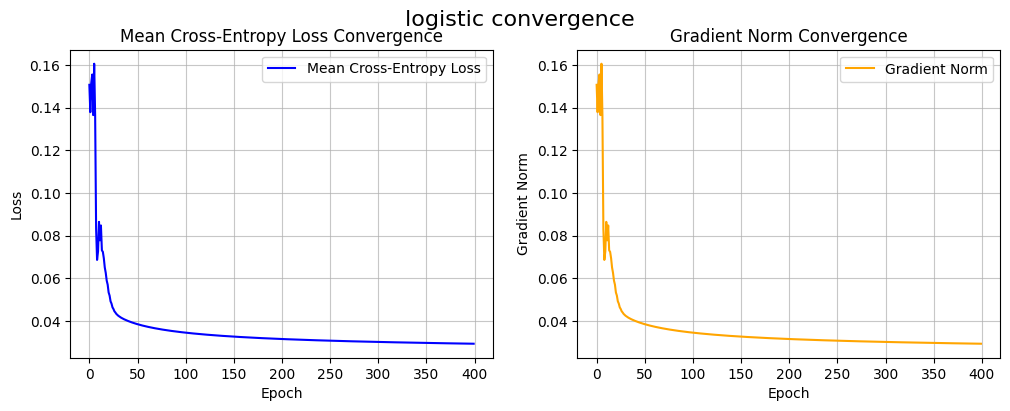

In [ ]:
LEARNING_RATE = 1
NORMALIZE = True
GRADIENT_TRESHOLD = 1e-5
E_IN_TRESHOLD = 0.5
MAX_REG_ITER = 400

# normelize data
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# fit
clf = LogisticRegression(MAX_REG_ITER, LEARNING_RATE, GRADIENT_TRESHOLD, E_IN_TRESHOLD)
clf.fit(X_train_normalized, y_train_onehot)

# pred
y_pred = clf.predict(X_test_normalized)

# plot convergence
plot_logistic_convergence(clf)

## Model Evaluation

**Multiclass Classification Result**

* accurency = ∑TPᵢ / (numer of samples)
* confustion matrix

accurency: 91.03 %



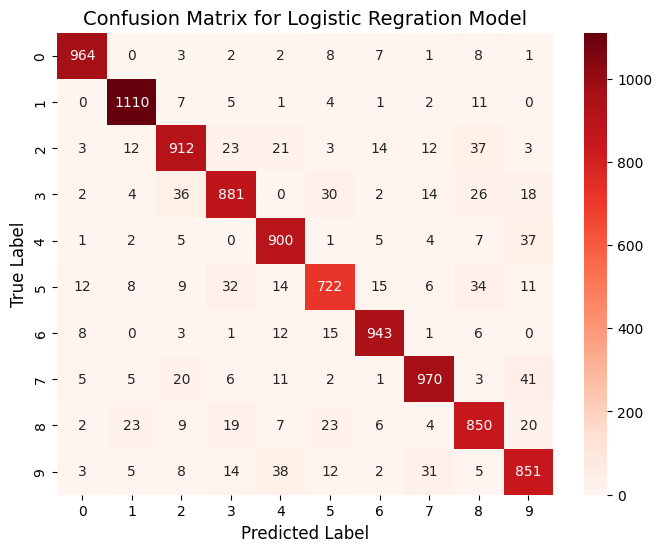

In [ ]:
# accurency
acc = accuracy_score(y_test_true, y_pred)
print(f"accurency: {100*acc} %\n")

# multy class confusion matrix
conf_mat = confusion_matrix(y_test_true, y_pred)
plot_multiclass_confusion_matrix(conf_mat,
                                 "Confusion Matrix for Logistic Regration Model")

**Binary Classifier Results** <br>
For each classifier, we'll examine:

* **Confustion matrix**

* **Accurancy** - percentage of correctly classified samples. Calculte by the formula: `(TP+TN)/(TP+TN+FP+FN)`

* **Sensitivity** - percentage of actual positive samples that are correctly identified by the classifier. Calculte by the formula: `TP/(TP+FN)`



 Digit |  Accuracy   | Sensitivity |
-----------------------------------


show result:   0%|          | 0/10 [00:00<?, ?it/s]

   0   |   99.320    |   96.787    |
   1   |   99.100    |   97.283    |
   2   |   97.720    |   87.692    |
   3   |   97.660    |   86.969    |
   4   |   98.320    |   93.555    |
   5   |   97.610    |   83.662    |
   6   |   99.010    |   95.349    |
   7   |   98.310    |   91.165    |
   8   |   97.500    |   88.266    |
   9   |   97.510    |   87.822    |
----------------------------------- 



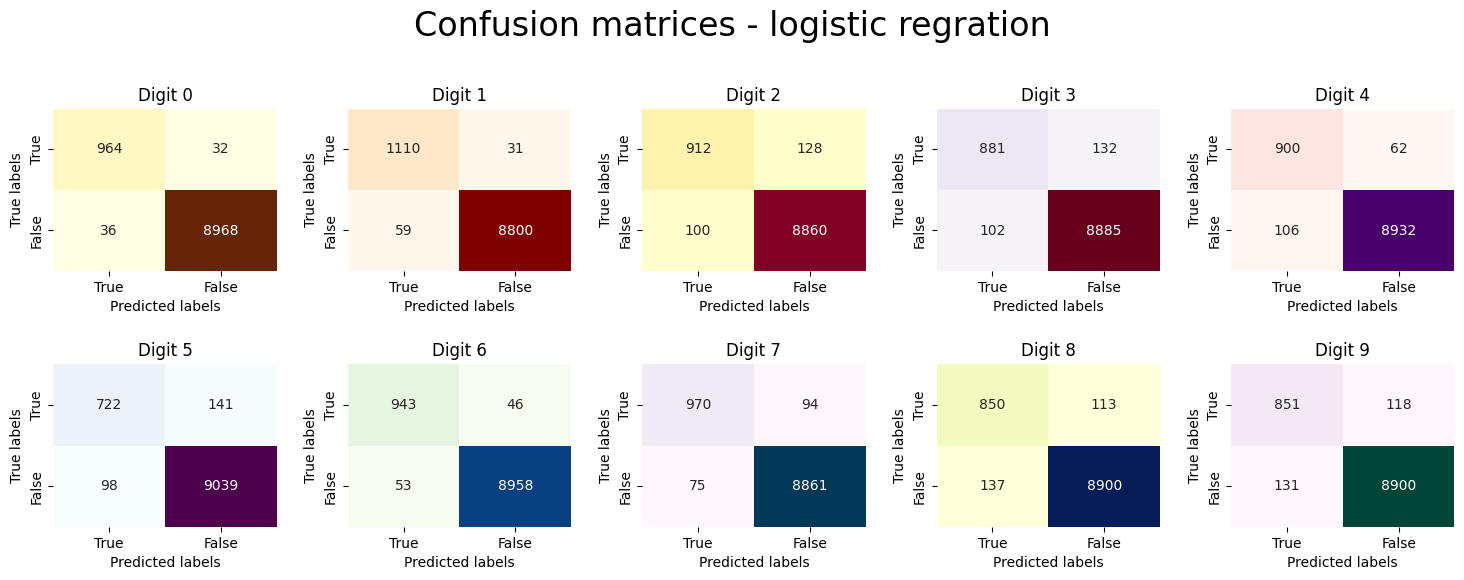

In [ ]:
conf_mat_arr =[]

print(f"{'Digit':^7}|{'Accuracy':^13}|{'Sensitivity':^13}|")
print("-" * 35)

for digit in tqdm(range(10), desc='show result', leave=False):
  digit_clf = classifiers[digit]
  y_digit_pred = np.where(y_pred == digit, 1, 0)
  y_digit_true = np.where(y_test_true == digit, 1, 0)
  conf_mat_arr.append(confusion_matrix(y_digit_true, y_digit_pred))

  # accuracy and sensitivity
  acc = accuracy_score(y_digit_true, y_digit_pred)
  sensitivity = recall_score(y_digit_true, y_digit_pred)
  print(f"{digit:^7}|{acc*100:^13.3f}|{sensitivity*100:^13.3f}|")

print("-" * 35, "\n")

# table of confotion for each digit
plot_confusion_matrices_side_by_side(conf_mat_arr, title="Confusion matrices - logistic regration")

##Hyperparameter choice

* **Learning Rate:** <br>
Initially, I focused on finding  an appropriate learing rate. My goal was to find a lr whose convergence graph would be smooth.
I tested different values of lr, as shown below, and found that `lr=1e-5` is the highest lr that gives smooth graph.
![image](https://drive.google.com/uc?export=view&id=1eG4Hm5ErfiS3rGNXRjIYQ_ImTEKkGfyn)
Therefor, I decided to try a different technique...

* **Normalize** <br>
To avoid such a small lr, I tried to normalizing the data by dividing by 255. With this approach, on the first try with lr=1, the model reached good accuracy and demonstrated smooth convergence with lr = 1, as showen above. Lower learning rates still produced good convergence but with lower accuracy, which led `lr=1` being the winning choise.

* **gradient treshold** and **Ein treshold** <br>
 In order to ensure the model converged, both of these thresholds were set to small values. `gradient_treshold=1e-5`, so we will be close a possible to minmum. However I wanted to avoid overfitting on the training set, therefore I chose `Ein_treshold=0.5`. In both cases, these thresholds were never met, and the model always ran until the last epoch.

* **max_iter** <br>
We can see that the graph flattens out after about 300 iterations, with no significant improvement in performance as the iterations increase. To reduce runtime, I chose `max_iter=400`, which provided good accurancy while significantly cutting down the training time.
![image](https://drive.google.com/uc?export=view&id=1P98DE4XjMd0VSrZl3ZhO0n_VRAOisi03)




###### **lr cheking**

In [ ]:
'''
# uncomment the cell in order to plot the graph of diffrent lr
# warning: it takes lot of time!!
'''

# LR_CHEAK = True

# if LR_CHEAK:
#   lr_val = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
#   color_list = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'purple']
#   accuracy_val = []
#   max_iter = 300


#   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
#   for idx in tqdm(range(len(lr_val)), desc="lr vals"):

#     # fit

#     clf_lr = LogisticRegression(max_iter, lr_val[idx], GRADIENT_TRESHOLD, E_IN_TRESHOLD)
#     clf_lr.fit(X_train, y_train_onehot)

#     # pred
#     y_pred = clf.predict(X_test)

#     # add graph
#     epochs, grad_norms, losses = zip(*clf_lr._train_history)
#     ax1.plot(epochs, grad_norms, label=f'lr={lr_val[idx]}', color=color_list[idx])
#     ax2.plot(epochs, losses, label=f'lr={lr_val[idx]}', color=color_list[idx])

#     accuracy_val.append(100*accuracy_score(y_test_true, y_pred))

#   # Gradient Norm Plot
#   ax1.set_xlabel('Epoch')
#   ax1.set_ylabel('Gradient Norm')
#   ax1.set_title('Gradient Norm Convergence')
#   ax1.legend()
#   ax1.grid(True, linestyle='--', alpha=0.7)

#   # Loss Plot
#   ax2.set_xlabel('Epoch')
#   ax2.set_ylabel('Loss')
#   ax2.set_title('Loss Convergence ')
#   ax2.legend()
#   ax2.grid(True, linestyle='--', alpha=0.7)

#   plt.tight_layout()
#   plt.show()



'\n# uncomment the cell in order to plot the graph of diffrent lr\n# warning: it takes lot of time!!\n'

## Result Discussion


* **Performance:** <br>
The model manages to provide better performance than the perceptron: logistic regression achieved an accuracy of around 91%, compared to 88% approximately for the perceptron. Additionally, the sensitivity of each digit is higher with the logistic regration. This suggesting that the data may be separable by non-linear boundaries.

* **Convergence:** <br>
the model required a very low learning rate or normalization the data, indicating that there is some noise in the data that needs to be corrected. Which may make it difficult to achieve a full separation between the digits

* **Time:** <br>
The runtime is slightly shorter than the perceptron (3 minutes instead of 4 minutes on my home computer). However, the model still requires a considerable amount of time to converge.

<br><br>
Overall, logistic regression provided better results with similar training times to the perceptron, making it a more effective model for this task.

# 📈 Linear Regression

In [ ]:
class LinearRegression:
  def __init__(self):
    self.w = None

  def fit(self, X, y):
    # Use pseudo-inverse
    # W = (XᵀX)-1y
    self.w = np.linalg.pinv(X.T @ X) @ X.T @ y

  def predict(self, X):
    return X @ self.w

  def loss(self, X, y):
    return np.mean((self.predict(X) - y)**2)

  def get_w(self):
    return self.w

## regular run
First, let's try using linear regression in the classic way.
Since linear regression gives a continuous prediction, we round each number to the nearest whole number to get the prediction.

In [ ]:
clf = LinearRegression()
clf.fit(X_train, y_train_true)

y_pred = np.round(clf.predict(X_test))

print(f"accurency: {100*accuracy_score(y_test_true, y_pred)} %")

accurency: 22.08 %


This approach did not work well and gave us poor results. <br>
This is because linear regression assumes a simple, straight-line relationship between the features and the classes. However multiclass classification problems are more complex than that. <br>
Consequently, the approximately the ~20% accuracy achieved by this simple linear regression approach is essentially equivalent to random chance

## one vs all
Similar to the Perceptron implementation, we can employ a one-vs-all strategy for linear regression where we train a separate linear regression model for each digit (0-9). Instead of using the direct output of the linear regression model (wᵀx) as the prediction, we treat it as a **"match score"** for the corresponding digit. Therefore, the hypothesis function for this approach becomes: `(x) = argmax(wᵀx)`


In [ ]:
class OneVsAllLinearRegration:
  def __init__(self):
    self._W = None

  def fit(self, X, Y):
    W = np.empty((X_train.shape[1],0)) # W = (w0, w1, ... , w9)
    k_classes = Y.shape[1]

    for digit in tqdm(range(k_classes), desc='Single digit linear regration'):
      # use the digit-th column of Y
      y_digit = Y[:, digit]

      # create Wi using linear regration
      clf = LinearRegression()
      clf.fit(X, y_digit)
      W = np.column_stack([W, clf.get_w()])
    self._W = W

  def predict(self, X):
    return np.argmax(X @ self._W, axis=1)

  def get_W(self):
    return self._W

In [ ]:

clf = OneVsAllLinearRegration()
clf.fit(X_train, y_signed_train)
y_pred = clf.predict(X_test)
# print(f"accurency: {100*accuracy_score(y_test_true, y_pred)} %")

Single digit linear regration:   0%|          | 0/10 [00:00<?, ?it/s]

## Model Evaluation


**Multiclass Classification Result**
* accurency = ∑TPᵢ / (numer of samples)
* confustion matrix

accurency: 84.88 %



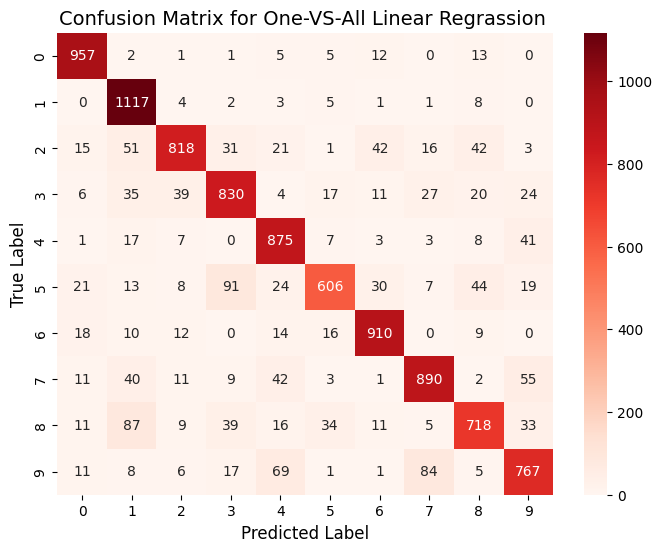

In [ ]:
# accurency
acc = accuracy_score(y_test_true, y_pred)
print(f"accurency: {100*acc} %\n")

# multy class confusion matrix
conf_mat = confusion_matrix(y_test_true, y_pred)
plot_multiclass_confusion_matrix(conf_mat,
                                 "Confusion Matrix for One-VS-All Linear Regrassion ")

**Binary Classifier Results** <br>
For each classifier, we'll examine:

* **Confustion matrix**

* **Accurancy** - percentage of correctly classified samples. Calculte by the formula: `(TP+TN)/(TP+TN+FP+FN)`

* **Sensitivity** - percentage of actual positive samples that are correctly identified by the classifier. Calculte by the formula: `TP/(TP+FN)`


 Digit |  Accuracy   | Sensitivity |
-----------------------------------


show result:   0%|          | 0/10 [00:00<?, ?it/s]

   0   |   98.670    |   96.084    |
   1   |   97.130    |   97.897    |
   2   |   96.810    |   78.654    |
   3   |   96.270    |   81.935    |
   4   |   97.150    |   90.956    |
   5   |   96.540    |   70.220    |
   6   |   98.090    |   92.012    |
   7   |   96.830    |   83.647    |
   8   |   96.040    |   74.559    |
   9   |   96.230    |   79.154    |
----------------------------------- 



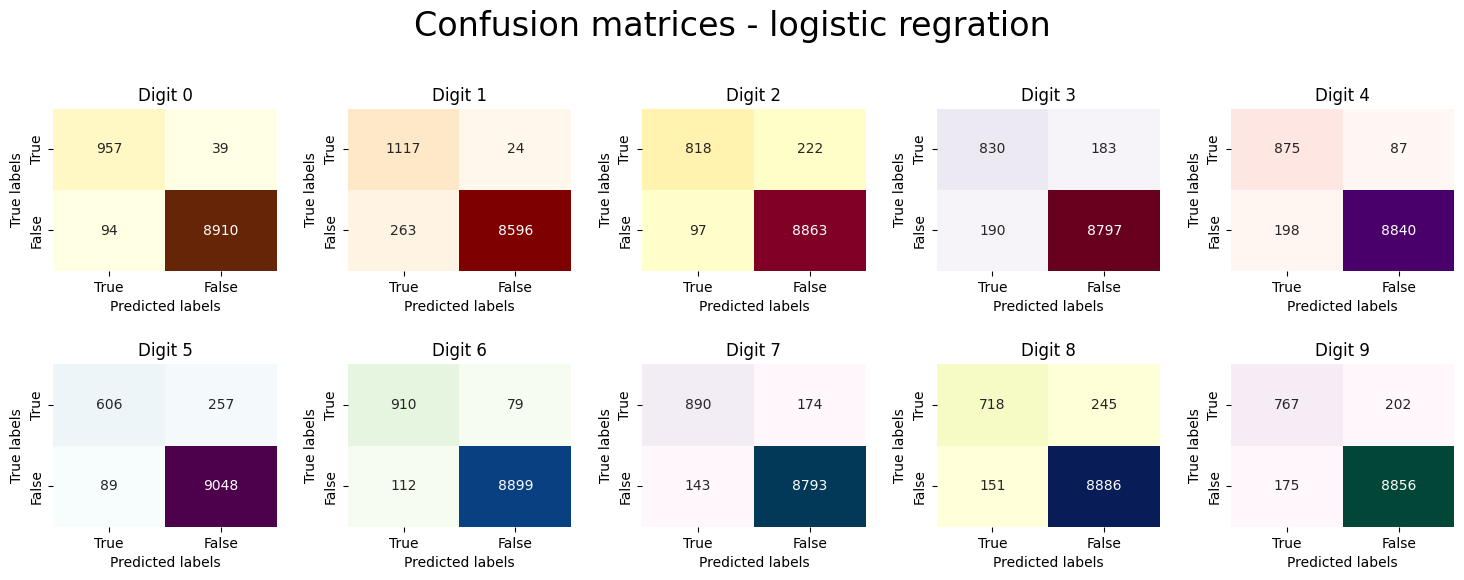

In [ ]:
conf_mat_arr =[]

print(f"{'Digit':^7}|{'Accuracy':^13}|{'Sensitivity':^13}|")
print("-" * 35)

for digit in tqdm(range(10), desc='show result', leave=False):
  digit_clf = classifiers[digit]
  y_digit_pred = np.where(y_pred == digit, 1, 0)
  y_digit_true = np.where(y_test_true == digit, 1, 0)
  conf_mat_arr.append(confusion_matrix(y_digit_true, y_digit_pred))

  # accuracy and sensitivity
  acc = accuracy_score(y_digit_true, y_digit_pred)
  sensitivity = recall_score(y_digit_true, y_digit_pred)
  print(f"{digit:^7}|{acc*100:^13.3f}|{sensitivity*100:^13.3f}|")

print("-" * 35, "\n")

# table of confotion for each digit
plot_confusion_matrices_side_by_side(conf_mat_arr, title="Confusion matrices - logistic regration")

## Result Discussion

* **performnce and time:** <br>
This approach achieved an accuracy of around 84% with minimal computational time, marking a significant improvement compared to the standard linear regression, which only reached around 20% accuracy. This is impressive, especially considering that both the Perceptron and linear regression models took several minutes to reach similar accuracy levels.

* **No future improvement:**<br>
Unlike the Perceptron and Logistic Regression models, where the weights are adjusted iteratively, the one-vs-all linear regression calculates the weights directly. The result that is reached is final and cannot be improved.

However, the weights obtained from this method could serve as a starting point for the Perceptron or for the Logistic Regression. Initializing these models with those weights might reduce their training time, as they would be starting from a good point.




<h1 align="center">
  <br>
  <a href="http://www.amitmerchant.com/electron-markdownify"><img src="https://raw.githubusercontent.com/amitmerchant1990/electron-markdownify/master/app/img/markdownify.png" alt="Markdownify" width="200"></a>
  <br>
  Markdownify
  <br>
</h1>

<h4 align="center">A minimal Markdown Editor desktop app built on top of <a href="http://electron.atom.io" target="_blank">Electron</a>.</h4>

<p align="center">
  <a href="https://badge.fury.io/js/electron-markdownify">
    <img src="https://badge.fury.io/js/electron-markdownify.svg"
         alt="Gitter">
  </a>
  <a href="https://gitter.im/amitmerchant1990/electron-markdownify"><img src="https://badges.gitter.im/amitmerchant1990/electron-markdownify.svg"></a>
  <a href="https://saythanks.io/to/bullredeyes@gmail.com">
      <img src="https://img.shields.io/badge/SayThanks.io-%E2%98%BC-1EAEDB.svg">
  </a>
  <a href="https://www.paypal.me/AmitMerchant">
    <img src="https://img.shields.io/badge/$-donate-ff69b4.svg?maxAge=2592000&amp;style=flat">
  </a>
</p>

<p align="center">
  <a href="#key-features">Key Features</a> •
  <a href="#how-to-use">How To Use</a> •
  <a href="#download">Download</a> •
  <a href="#credits">Credits</a> •
  <a href="#related">Related</a> •
  <a href="#license">License</a>
</p>

![screenshot](https://raw.githubusercontent.com/amitmerchant1990/electron-markdownify/master/app/img/markdownify.gif)

## Key Features

* LivePreview - Make changes, See changes
  - Instantly see what your Markdown documents look like in HTML as you create them.
* Sync Scrolling
  - While you type, LivePreview will automatically scroll to the current location you're editing.
* GitHub Flavored Markdown  
* Syntax highlighting
* [KaTeX](https://khan.github.io/KaTeX/) Support
* Dark/Light mode
* Toolbar for basic Markdown formatting
* Supports multiple cursors
* Save the Markdown preview as PDF
* Emoji support in preview :tada:
* App will keep alive in tray for quick usage
* Full screen mode
  - Write distraction free.
* Cross platform
  - Windows, macOS and Linux ready.

## How To Use

To clone and run this application, you'll need [Git](https://git-scm.com) and [Node.js](https://nodejs.org/en/download/) (which comes with [npm](http://npmjs.com)) installed on your computer. From your command line:

```bash
# Clone this repository
$ git clone https://github.com/amitmerchant1990/electron-markdownify

# Go into the repository
$ cd electron-markdownify

# Install dependencies
$ npm install

# Run the app
$ npm start
```

> **Note**
> If you're using Linux Bash for Windows, [see this guide](https://www.howtogeek.com/261575/how-to-run-graphical-linux-desktop-applications-from-windows-10s-bash-shell/) or use `node` from the command prompt.


## Download

You can [download](https://github.com/amitmerchant1990/electron-markdownify/releases/tag/v1.2.0) the latest installable version of Markdownify for Windows, macOS and Linux.

## Emailware

Markdownify is an [emailware](https://en.wiktionary.org/wiki/emailware). Meaning, if you liked using this app or it has helped you in any way, I'd like you send me an email at <bullredeyes@gmail.com> about anything you'd want to say about this software. I'd really appreciate it!

## Credits

This software uses the following open source packages:

- [Electron](http://electron.atom.io/)
- [Node.js](https://nodejs.org/)
- [Marked - a markdown parser](https://github.com/chjj/marked)
- [showdown](http://showdownjs.github.io/showdown/)
- [CodeMirror](http://codemirror.net/)
- Emojis are taken from [here](https://github.com/arvida/emoji-cheat-sheet.com)
- [highlight.js](https://highlightjs.org/)

## Related

[Try Web version of Markdownify](https://notepad.js.org/markdown-editor/)

## Support

<a href="https://buymeacoffee.com/amitmerchant" target="_blank"><img src="https://www.buymeacoffee.com/assets/img/custom_images/purple_img.png" alt="Buy Me A Coffee" style="height: 41px !important;width: 174px !important;box-shadow: 0px 3px 2px 0px rgba(190, 190, 190, 0.5) !important;-webkit-box-shadow: 0px 3px 2px 0px rgba(190, 190, 190, 0.5) !important;" ></a>

<p>Or</p>

<a href="https://www.patreon.com/amitmerchant">
	<img src="https://c5.patreon.com/external/logo/become_a_patron_button@2x.png" width="160">
</a>

## You may also like...

- [Pomolectron](https://github.com/amitmerchant1990/pomolectron) - A pomodoro app
- [Correo](https://github.com/amitmerchant1990/correo) - A menubar/taskbar Gmail App for Windows and macOS

## License

MIT

---

> [amitmerchant.com](https://www.amitmerchant.com) &nbsp;&middot;&nbsp;
> GitHub [@amitmerchant1990](https://github.com/amitmerchant1990) &nbsp;&middot;&nbsp;
> Twitter [@amit_merchant](https://twitter.com/amit_merchant)

